In [159]:
from flask import Flask, render_template
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from io import BytesIO
import base64

In [160]:
app = Flask(__name__)


In [161]:
playstore = pd.read_csv('data/googleplaystore.csv')
playstore.drop_duplicates(subset = ['App'], keep='first',inplace=True) 
playstore.drop([10472], inplace=True)
playstore.Category = playstore.Category.astype('category')
playstore.Installs = playstore.Installs.apply(lambda x: x.replace(',',''))
playstore.Installs = playstore.Installs.apply(lambda x: x.replace('+',''))
playstore.Installs = playstore.Installs.astype('int64')
playstore['Size'].replace('Varies with device', np.nan, inplace = True ) 
playstore.Size = (playstore.Size.replace(r'[kM]+$', '', regex=True).astype(float) * \
             playstore.Size.str.extract(r'[\d\.]+([kM]+)', expand=False)
            .fillna(1)
            .replace(['k','M'], [10**3, 10**6]).astype(int))
playstore['Size'].fillna(playstore.groupby('Category')['Size'].transform('mean'),inplace = True)
playstore.Price = playstore.Price.apply(lambda x: x.replace('$',''))
playstore.Price = playstore.Price.astype('float64')
playstore[['Reviews', 'Size']] = playstore[['Reviews', 'Size']].astype('int64')

In [162]:
df2 = playstore.copy()

In [163]:
top_category = pd.crosstab(
    index= df2['Category'],
    columns= 'Jumlah'
).sort_values(by='Jumlah', ascending=False).reset_index().head()
top_category

col_0,Category,Jumlah
0,FAMILY,1832
1,GAME,959
2,TOOLS,827
3,BUSINESS,420
4,MEDICAL,395


In [164]:
top_category.head()

col_0,Category,Jumlah
0,FAMILY,1832
1,GAME,959
2,TOOLS,827
3,BUSINESS,420
4,MEDICAL,395


In [165]:
top_category['Category'][0]

'FAMILY'

In [166]:
top_category['Jumlah'][0]

1832

In [167]:
df2[['Category','App','Reviews','Rating']].groupby(['Category','App']).agg({
    'Reviews':'sum',
    'Rating':'mean'}).sort_values(by='Reviews',ascending=False).head(10).reset_index()

,Category,App,Reviews,Rating
0,SOCIAL,Facebook,78158306.0,4.1
1,COMMUNICATION,WhatsApp Messenger,69119316.0,4.4
2,SOCIAL,Instagram,66577313.0,4.5
3,COMMUNICATION,Messenger – Text and Video Chat for Free,56642847.0,4.0
4,GAME,Clash of Clans,44891723.0,4.6
5,TOOLS,Clean Master- Space Cleaner & Antivirus,42916526.0,4.7
6,GAME,Subway Surfers,27722264.0,4.5
7,VIDEO_PLAYERS,YouTube,25655305.0,4.3
8,TOOLS,"Security Master - Antivirus, VPN, AppLock, Boo...",24900999.0,4.7
9,GAME,Clash Royale,23133508.0,4.6


In [168]:
stats = {
    'most_categories' : top_category['Category'][0],
    'Total' : top_category['Jumlah'][0],
    'rev_table' : df2[['Category','App','Reviews','Rating']].groupby(['Category','App']).agg({'Reviews':'sum','Rating':'mean'}).sort_values(by='Reviews',ascending=False).head(10).reset_index()   
}

In [169]:
df2

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19000000,10000,Free,0.0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14000000,500000,Free,0.0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8700000,5000000,Free,0.0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25000000,50000000,Free,0.0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2800000,100000,Free,0.0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10836,Sya9a Maroc - FR,FAMILY,4.5,38,53000000,5000,Free,0.0,Everyone,Education,"July 25, 2017",1.48,4.1 and up
10837,Fr. Mike Schmitz Audio Teachings,FAMILY,5.0,4,3600000,100,Free,0.0,Everyone,Education,"July 6, 2018",1.0,4.1 and up
10838,Parkinson Exercices FR,MEDICAL,NaN,3,9500000,1000,Free,0.0,Everyone,Medical,"January 20, 2017",1.0,2.2 and up
10839,The SCP Foundation DB fr nn5n,BOOKS_AND_REFERENCE,4.5,114,13134701,1000,Free,0.0,Mature 17+,Books & Reference,"January 19, 2015",Varies with device,Varies with device


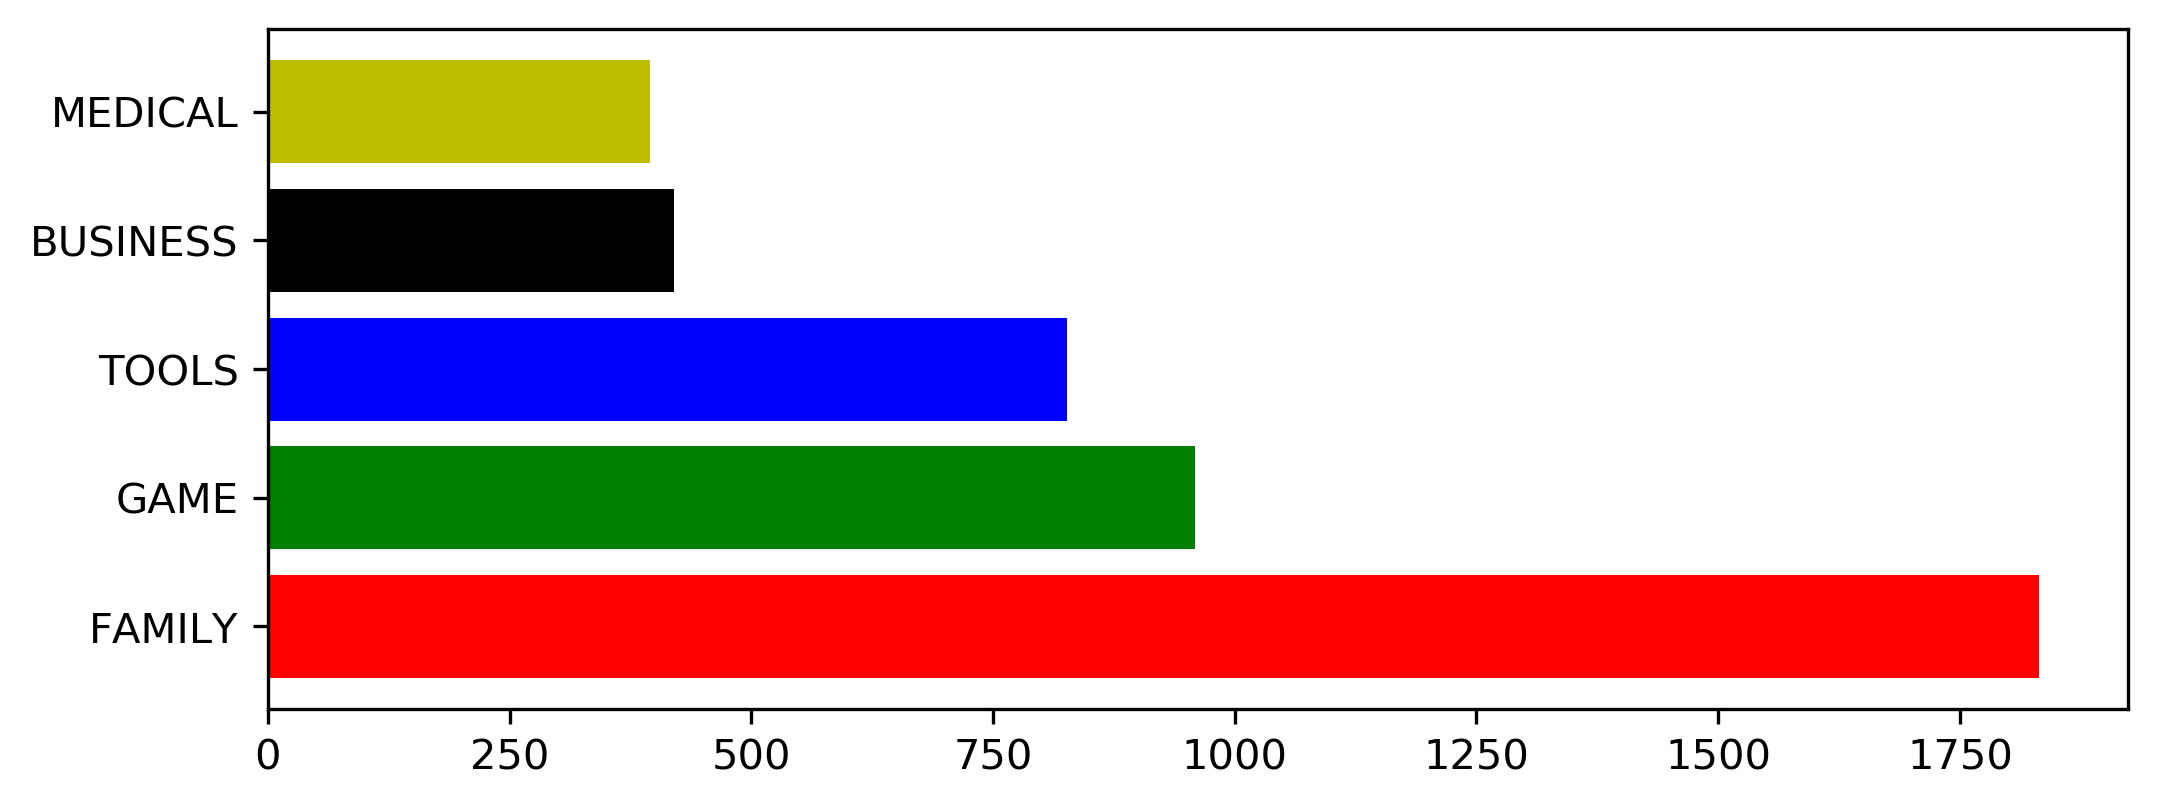

In [187]:
cat_order = df2.groupby('Category').agg({
    'Category' : 'count'
        }).rename({'Category':'Total'}, axis=1).sort_values(by='Total', ascending = False).head()
X = cat_order.index
Y = cat_order['Total']
my_colors = 'rgbkymc'

fig = plt.figure(figsize=(8,3),dpi=300)
fig.add_subplot()
plt.barh(X,Y, color=my_colors)
plt.savefig('cat_order.png',bbox_inches="tight") 

figfile = BytesIO()
plt.savefig(figfile, format='png')
figfile.seek(0)
figdata_png = base64.b64encode(figfile.getvalue())

result = str(figdata_png)[2:-1]

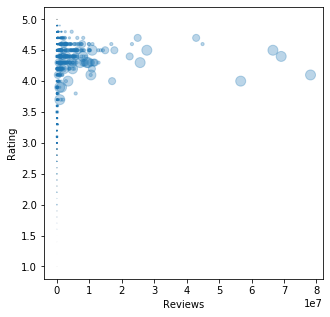

In [191]:
X = df2['Reviews'].values # axis x
Y = df2['Rating'].values # axis y
area = playstore['Installs'].values/10000000 # ukuran besar/kecilnya lingkaran scatter plot
fig = plt.figure(figsize=(5,5))
fig.add_subplot()

plt.scatter(x= X,y= Y, s=area, alpha=0.3)
plt.xlabel('Reviews')
plt.ylabel('Rating')
plt.savefig('rev_rat.png',bbox_inches="tight")

figfile = BytesIO()
plt.savefig(figfile, format='png')
figfile.seek(0)
figdata_png = base64.b64encode(figfile.getvalue())
result2 = str(figdata_png)[2:-1]

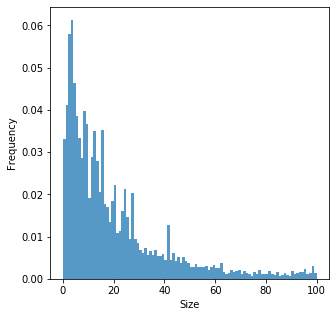

In [192]:
X=(playstore.Size/1000000).values
fig = plt.figure(figsize=(5,5))
fig.add_subplot()
plt.hist(X,bins=100, density=True,  alpha=0.75)
plt.xlabel('Size')
plt.ylabel('Frequency')
plt.savefig('hist_size.png',bbox_inches="tight")

figfile = BytesIO()
plt.savefig(figfile, format='png')
figfile.seek(0)
figdata_png = base64.b64encode(figfile.getvalue())
result3 = str(figdata_png)[2:-1]

In [194]:
playstore.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19000000,10000,Free,0.0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14000000,500000,Free,0.0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8700000,5000000,Free,0.0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25000000,50000000,Free,0.0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2800000,100000,Free,0.0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


In [203]:
playstore['Genres']=playstore['Genres'].astype('category')

In [218]:
popular_genre

col_0,Popularity
Genres,
Communication,3.504215e+07
Video Players & Editors,2.417841e+07
Social,2.296179e+07
Adventure;Action & Adventure,2.123000e+07
Arcade,2.040831e+07
Casual,1.850200e+07
Puzzle;Action & Adventure,1.836667e+07
Educational;Action & Adventure,1.701667e+07
Photography,1.654501e+07


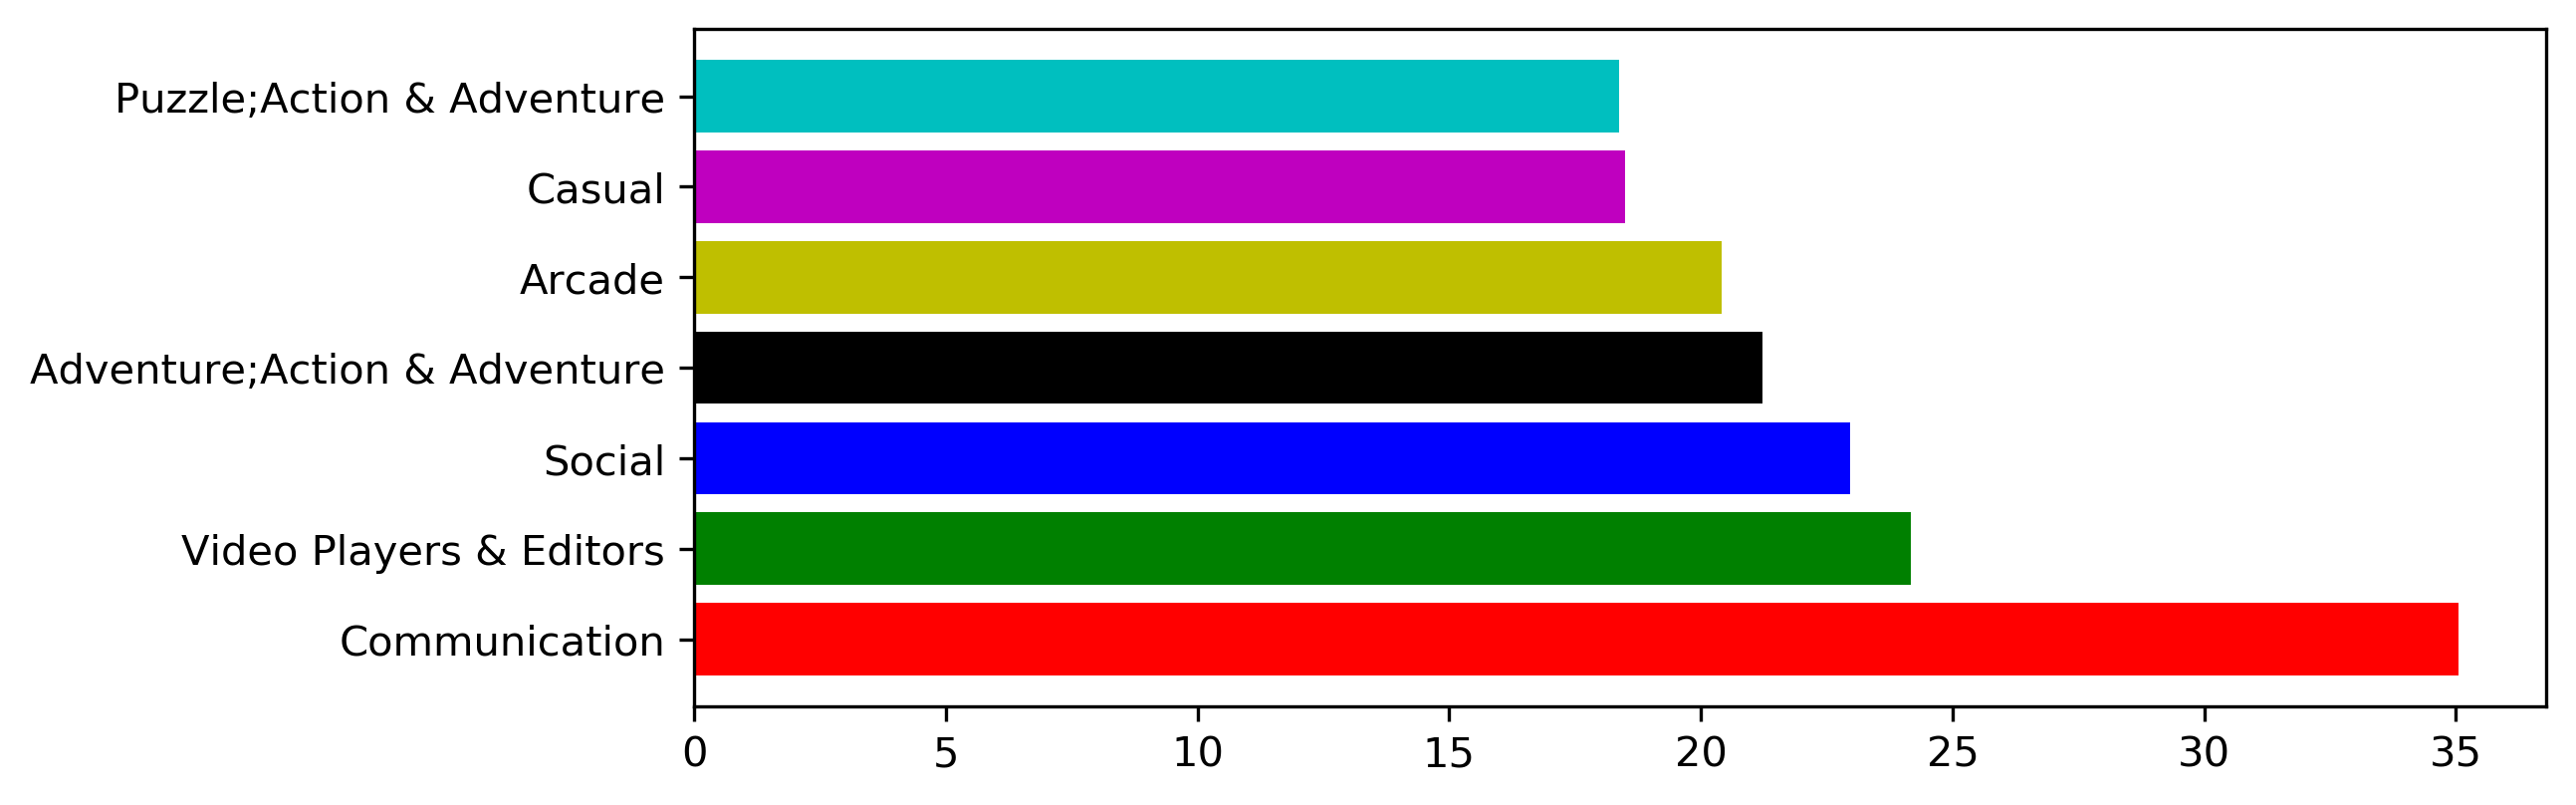

In [227]:
popular_genre = pd.crosstab(
    index= playstore['Genres'],
    columns= 'Popularity',
    values= playstore['Installs'],
    aggfunc= 'mean'
).sort_values(by='Popularity', ascending=False).head(7)

X = popular_genre.index
Y = (popular_genre['Popularity']/1000000).values
my_colors = 'rgbkymc'

fig = plt.figure(figsize=(8,3),dpi=300)
fig.add_subplot()
plt.barh(X,Y, color=my_colors)
plt.savefig('cat_order.png',bbox_inches="tight") 

figfile = BytesIO()
plt.savefig(figfile, format='png')
figfile.seek(0)
figdata_png = base64.b64encode(figfile.getvalue())


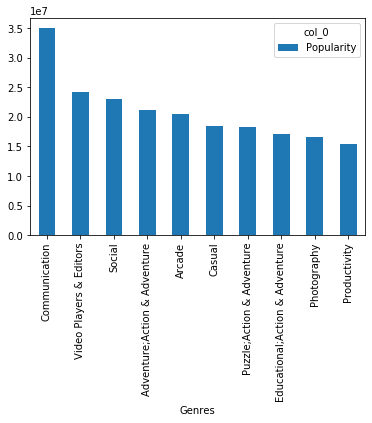